In [18]:
import ants
import os
import SimpleITK as sitk
from glob import glob
import numpy as np
from tqdm import tqdm 
import nibabel as nib

### Register and resample images

1 - visualize the untouched images

2 - get rid of the affine matrix by replacing it with a 4x4 eye matrix

3 - orient the images in the right direction (eg with 90 deg rotations)

4 - Use ants to do affine registration


In [19]:
ROOT_DIR = "/home/fehrdelt/bettik/"
#ROOT_DIR = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/"

In [20]:
input_folder = ROOT_DIR+"datasets/ISLES_ADC/"
input_folder_masks = ROOT_DIR+"datasets/ISLES_masks/"

rotated_output_folder = ROOT_DIR+"datasets/ISLES_ADC_rotated/"
rotated_output_folder_masks = ROOT_DIR+"datasets/ISLES_masks_rotated/"

output_folder = ROOT_DIR+"datasets/ISLES_ADC_registered_resampled/"
output_folder_masks = ROOT_DIR+"datasets/ISLES_masks_registered_resampled/"



#reference_image_path = ROOT_DIR+"datasets/dataset_IXI_T1_brain_extraction/IXI002-Guys-0828-T1.nii.gz"
reference_image_path = ROOT_DIR+"datasets/fixed_reference_hcp_ya_128.nii.gz"

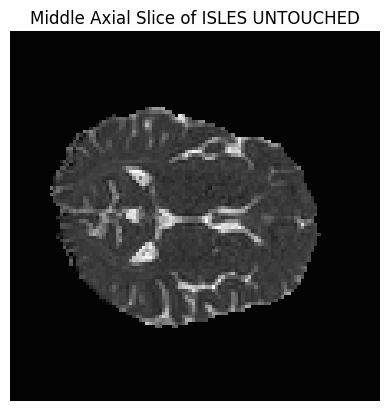

In [21]:
import matplotlib.pyplot as plt

# Load the first image from input_folder using nibabel
test_isles_untouched_image_path = input_folder+os.listdir(input_folder)[0]
test_isles_untouched_image = nib.load(test_isles_untouched_image_path)

# Extract the image data as a numpy array
test_isles_untouched_image_data = test_isles_untouched_image.get_fdata()
#test_isles_untouched_image_data = np.rot90(test_isles_untouched_image_data, k=1, axes=(0, 1))  # Rotate the image data by 90 degrees

# Calculate the middle slice index along the axial direction
test_isles_untouched_middle_axial_index = test_isles_untouched_image_data.shape[2] // 2

# Extract the middle axial slice
test_isles_untouched_middle_axial_slice = test_isles_untouched_image_data[:, :, test_isles_untouched_middle_axial_index]

# Display the slice
plt.imshow(test_isles_untouched_middle_axial_slice, cmap="gray")
plt.title("Middle Axial Slice of ISLES UNTOUCHED")
plt.axis("off")
plt.show()

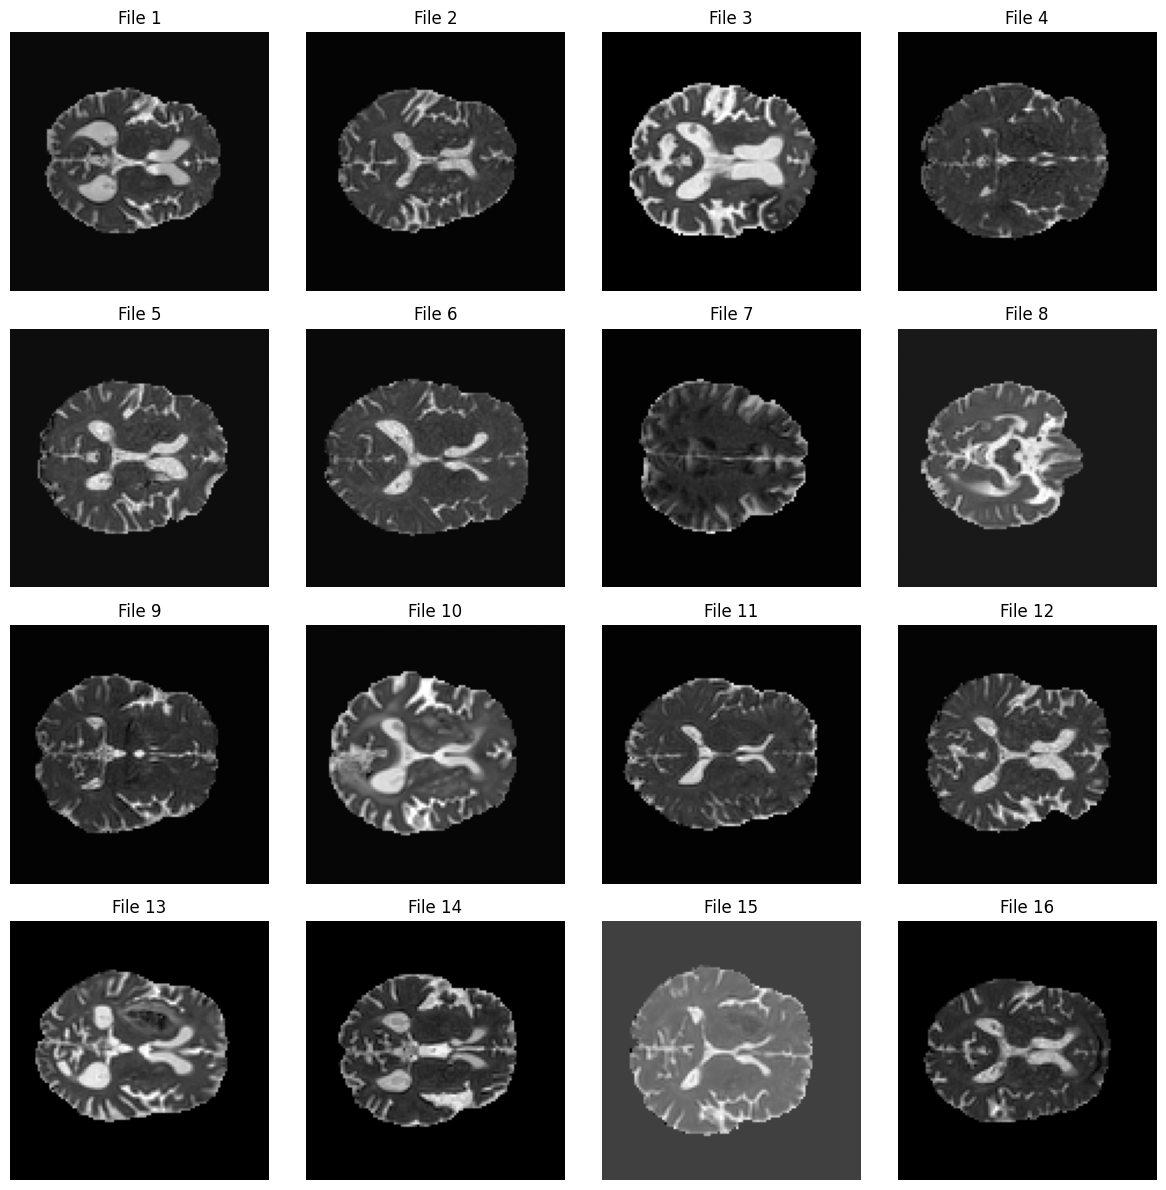

In [22]:
import matplotlib.pyplot as plt

# Get the first 16 files from the output folder
first_16_files = sorted(os.listdir(input_folder))[:16]

# Create a grid to display the slices
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, file in enumerate(first_16_files):
    if file.endswith(".nii") or file.endswith(".gz"):
        # Load the image
        image_path = os.path.join(input_folder, file)
        image = nib.load(image_path)
        image_data = image.get_fdata()

        # Calculate the middle axial slice index
        middle_axial_index = image_data.shape[2] // 2

        # Extract the middle axial slice
        middle_axial_slice = image_data[:, :, middle_axial_index]

        # Display the slice in the grid
        ax = axes[i // 4, i % 4]
        ax.imshow(middle_axial_slice, cmap="gray")
        ax.set_title(f"File {i+1}")
        ax.axis("off")

plt.tight_layout()
plt.show()

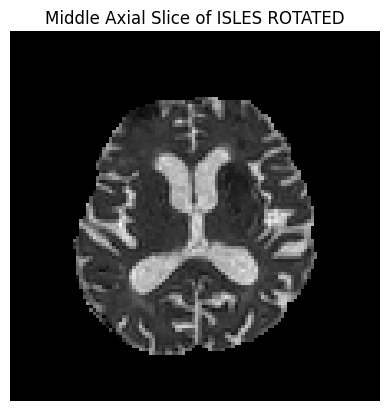

In [23]:
import matplotlib.pyplot as plt

# Load the first image from input_folder using nibabel
test_adc_rotated_image_path = rotated_output_folder+os.listdir(rotated_output_folder)[0]
test_adc_rotated_image = nib.load(test_adc_rotated_image_path)

# Extract the image data as a numpy array
test_adc_rotated_image_data = test_adc_rotated_image.get_fdata()
#test_adc_rotated_image_data = np.rot90(test_adc_rotated_image_data, k=1, axes=(0, 1))  # Rotate the image data by 90 degrees

# Calculate the middle slice index along the axial direction
test_adc_rotated_middle_axial_index = test_adc_rotated_image_data.shape[2] // 2

# Extract the middle axial slice
test_adc_rotated_middle_axial_slice = test_adc_rotated_image_data[:, :, test_adc_rotated_middle_axial_index]

# Display the slice
plt.imshow(test_adc_rotated_middle_axial_slice, cmap="gray")
plt.title("Middle Axial Slice of ISLES ROTATED")
plt.axis("off")
plt.show()

In [38]:
os.makedirs(rotated_output_folder, exist_ok=True)

# rotate 90 deg
for file in tqdm(os.listdir(input_folder)):
    if file.endswith(".nii") or file.endswith(".gz"):
        # Load the image
        image_path = os.path.join(input_folder, file)
        image = nib.load(image_path)
        image_data = image.get_fdata()

        file_mask = file.replace("adc.nii.gz", "msk.nii.gz")
        mask_path = os.path.join(input_folder_masks, file_mask)
        mask = nib.load(mask_path)
        mask_data = mask.get_fdata()

        # Rotate the image data
        rotated_image_data = np.rot90(image_data, k=1, axes=(0, 1))
        rotated_mask_data = np.rot90(mask_data, k=1, axes=(0, 1))

        # Create a new NIfTI image with the rotated data
        empty_header = nib.Nifti1Header()
        rotated_image = nib.Nifti1Image(rotated_image_data, affine=np.eye(4), header=empty_header)
        rotated_mask = nib.Nifti1Image(rotated_mask_data, affine=np.eye(4), header=empty_header)
        #rotated_image = nib.Nifti1Image(rotated_data, affine=image.affine, header=empty_header)

        # Save the rotated image to the output folder
        rotated_image_path = os.path.join(rotated_output_folder, file)
        rotated_mask_path = os.path.join(rotated_output_folder_masks, file_mask)
        nib.save(rotated_image, rotated_image_path)
        nib.save(rotated_mask, rotated_mask_path)


"""
# rotate 90 deg, taking affine into account (chatgpt)
for file in tqdm(os.listdir(input_folder)):
    if file.endswith(".nii") or file.endswith(".gz"):
        # Load the image
        image_path = os.path.join(input_folder, file)
        image = nib.load(image_path)
        data = image.get_fdata()
        affine = image.affine
        # Rotate 90 degrees counter-clockwise in the (0, 1) plane
        rotated_data = np.rot90(data, k=1, axes=(0, 1))

        # Define voxel rotation matrix
        R_vox = np.array([
            [0, -1,  0],
            [1,  0,  0],
            [0,  0,  1]
        ])

        # Update the rotation part of the affine
        new_affine = affine.copy()
        new_affine[:3, :3] = affine[:3, :3] @ R_vox

        # Recalculate translation to keep the image in the correct location
        # This accounts for the shift due to rotation
        new_origin_shift = np.dot(new_affine[:3, :3], np.array(rotated_data.shape) / 2)
        new_affine[:3, 3] = affine[:3, 3] + affine[:3, :3] @ (np.array(data.shape)/2 - np.array(rotated_data.shape)/2)

        # Save rotated image
        rotated_img = nib.Nifti1Image(rotated_data, new_affine)
        rotated_image_path = os.path.join(rotated_output_folder, file)
        nib.save(rotated_img, rotated_image_path)
"""        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:45<00:00,  5.50it/s]


'\n# rotate 90 deg, taking affine into account (chatgpt)\nfor file in tqdm(os.listdir(input_folder)):\n    if file.endswith(".nii") or file.endswith(".gz"):\n        # Load the image\n        image_path = os.path.join(input_folder, file)\n        image = nib.load(image_path)\n        data = image.get_fdata()\n        affine = image.affine\n        # Rotate 90 degrees counter-clockwise in the (0, 1) plane\n        rotated_data = np.rot90(data, k=1, axes=(0, 1))\n\n        # Define voxel rotation matrix\n        R_vox = np.array([\n            [0, -1,  0],\n            [1,  0,  0],\n            [0,  0,  1]\n        ])\n\n        # Update the rotation part of the affine\n        new_affine = affine.copy()\n        new_affine[:3, :3] = affine[:3, :3] @ R_vox\n\n        # Recalculate translation to keep the image in the correct location\n        # This accounts for the shift due to rotation\n        new_origin_shift = np.dot(new_affine[:3, :3], np.array(rotated_data.shape) / 2)\n        new

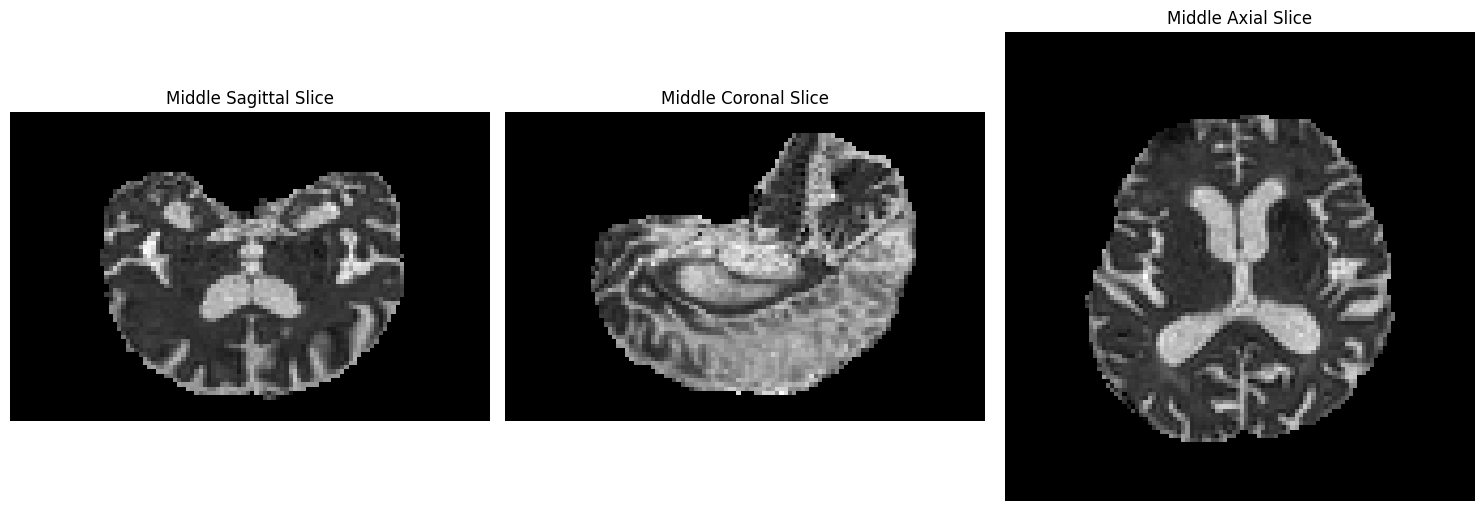

In [8]:
import matplotlib.pyplot as plt

# Load the first image from input_folder using nibabel
test_rotated_image_path = rotated_output_folder+os.listdir(rotated_output_folder)[0]
test_rotated_image = nib.load(test_rotated_image_path)

# Extract the image data as a numpy array
test_rotated_image_data = test_rotated_image.get_fdata()

# Calculate the middle slice indices along each axis
middle_indices = [
    test_rotated_image_data.shape[0] // 2,  # Sagittal
    test_rotated_image_data.shape[1] // 2,  # Coronal
    test_rotated_image_data.shape[2] // 2   # Axial
]

# Extract the middle slices along each axis
sagittal_slice = test_rotated_image_data[middle_indices[0], :, :]
coronal_slice = test_rotated_image_data[:, middle_indices[1], :]
axial_slice = test_rotated_image_data[:, :, middle_indices[2]]

# Display the slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sagittal_slice.T, cmap="gray")
axes[0].set_title("Middle Sagittal Slice")
axes[0].axis("off")

axes[1].imshow(coronal_slice.T, cmap="gray")
axes[1].set_title("Middle Coronal Slice")
axes[1].axis("off")

axes[2].imshow(axial_slice, cmap="gray")
axes[2].set_title("Middle Axial Slice")
axes[2].axis("off")

plt.tight_layout()
plt.show()

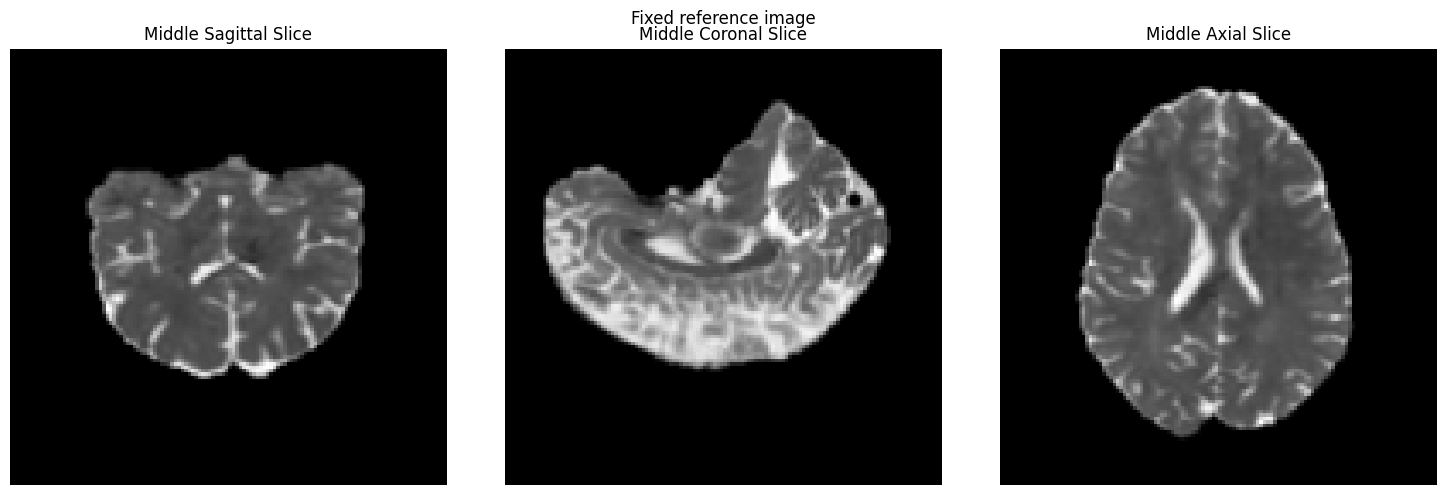

In [9]:
import matplotlib.pyplot as plt

# Load the first image from input_folder using nibabel
fixed_reference_image_path = ROOT_DIR+"datasets/reference_ADC_resampled.nii"
fixed_reference_image = nib.load(fixed_reference_image_path)

# Extract the image data as a numpy array
fixed_reference_image_data = fixed_reference_image.get_fdata()

# Calculate the middle slice indices along each axis
middle_indices = [
    fixed_reference_image_data.shape[0] // 2,  # Sagittal
    fixed_reference_image_data.shape[1] // 2,  # Coronal
    fixed_reference_image_data.shape[2] // 2   # Axial
]

# Extract the middle slices along each axis
sagittal_slice = fixed_reference_image_data[middle_indices[0], :, :]
coronal_slice = fixed_reference_image_data[:, middle_indices[1], :]
axial_slice = fixed_reference_image_data[:, :, middle_indices[2]]

# Display the slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sagittal_slice.T, cmap="gray")
axes[0].set_title("Middle Sagittal Slice")
axes[0].axis("off")

axes[1].imshow(coronal_slice.T, cmap="gray")
axes[1].set_title("Middle Coronal Slice")
axes[1].axis("off")

axes[2].imshow(axial_slice, cmap="gray")
axes[2].set_title("Middle Axial Slice")
axes[2].axis("off")
plt.suptitle("Fixed reference image")
plt.tight_layout()
plt.show()

In [10]:
def histogram_match_nifti(input_image_path, reference_image_path, output_image_path):
    """
    Performs histogram matching on a 3D NIfTI image based on a reference image.

    Parameters:
    - input_image_path: Path to the input NIfTI image to be matched.
    - reference_image_path: Path to the reference NIfTI image.
    - output_image_path: Path to save the histogram-matched NIfTI image.
    """
    # Load the input and reference images using SimpleITK
    input_image = sitk.ReadImage(input_image_path, sitk.sitkFloat32)
    reference_image = sitk.ReadImage(reference_image_path, sitk.sitkFloat32)

    # Perform histogram matching
    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(256)
    matcher.SetNumberOfMatchPoints(15)
    matcher.SetThresholdAtMeanIntensity(True)

    matched_image = matcher.Execute(input_image, reference_image)

    # Save the matched image
    sitk.WriteImage(matched_image, output_image_path)

In [11]:
histogram_match_nifti(input_image_path=fixed_reference_image_path, reference_image_path=test_rotated_image_path, output_image_path=ROOT_DIR+"datasets/reference_ADC_resampled_histogram_matched.nii.gz")

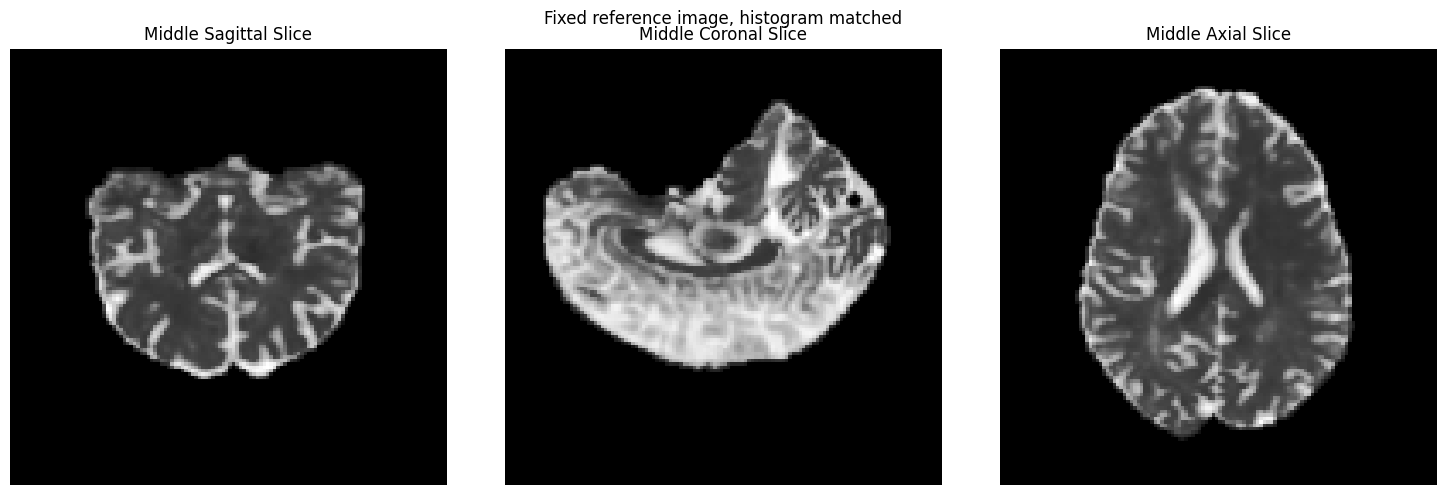

In [12]:
import matplotlib.pyplot as plt

# Load the first image from input_folder using nibabel
fixed_reference_image_path = ROOT_DIR+"datasets/reference_ADC_resampled_histogram_matched.nii.gz"
fixed_reference_image = nib.load(fixed_reference_image_path)

# Extract the image data as a numpy array
fixed_reference_image_data = fixed_reference_image.get_fdata()

# Calculate the middle slice indices along each axis
middle_indices = [
    fixed_reference_image_data.shape[0] // 2,  # Sagittal
    fixed_reference_image_data.shape[1] // 2,  # Coronal
    fixed_reference_image_data.shape[2] // 2   # Axial
]

# Extract the middle slices along each axis
sagittal_slice = fixed_reference_image_data[middle_indices[0], :, :]
coronal_slice = fixed_reference_image_data[:, middle_indices[1], :]
axial_slice = fixed_reference_image_data[:, :, middle_indices[2]]

# Display the slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sagittal_slice.T, cmap="gray")
axes[0].set_title("Middle Sagittal Slice")
axes[0].axis("off")

axes[1].imshow(coronal_slice.T, cmap="gray")
axes[1].set_title("Middle Coronal Slice")
axes[1].axis("off")

axes[2].imshow(axial_slice, cmap="gray")
axes[2].set_title("Middle Axial Slice")
axes[2].axis("off")
plt.suptitle("Fixed reference image, histogram matched")
plt.tight_layout()
plt.show()

In [44]:
def resample_img(itk_image, out_spacing=[1.0, 1.0, 1.0]):
    # Resample images to 2mspecified spacing with SimpleITK

    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())


    resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [45]:
def command_iteration(method):
    """ Callback invoked when the optimization has an iteration. """
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

In [46]:


def register_nifti_files(fixed_reference, dataset_path, output_path, register_masks=False, dataset_masks_path=None, output_mask_path=None):
    """
    Registers all NIfTI files in the dataset_path folder to the same space using ANTs.

    Parameters:
    - dataset_path: Path to the folder containing NIfTI files.
    - output_path: Path to save the registered NIfTI files.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Get all NIfTI files in the dataset_path
    nifti_files = sorted(glob(os.path.join(dataset_path, "*.nii*")))
    nifti_masks_files = sorted(glob(os.path.join(dataset_masks_path, "*.nii*")))
    print("nifti_files", nifti_files)
    if register_masks: print("nifti_masks_files", nifti_masks_files)
    if not nifti_files:
        print("No NIfTI files found in the dataset path.")
        return

    # Use the first file as the fixed image (reference)
    fixed_image = ants.image_read(fixed_reference)

    for i, moving_file in enumerate(nifti_files):
        print(f"file {i} of {len(nifti_files)}")
        output_filepath = os.path.join(output_path, os.path.basename(moving_file))

        if register_masks:
            mask_file = nifti_masks_files[i]
            output_mask_filepath = os.path.join(output_mask_path, os.path.basename(mask_file))
        
        
        if not os.path.isfile(output_filepath):
            moving_image = ants.image_read(moving_file)
            
            # Perform registration
            registration = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='Similarity') # https://antspy.readthedocs.io/en/latest/registration.html types of transforms

            # for the mask
            if register_masks:
                mask_image = ants.image_read(mask_file)
                transform = registration['fwdtransforms']
                mask_moved = ants.apply_transforms(fixed_image, mask_image, transformlist=transform, interpolation='nearestNeighbor')
                mask_moved.to_file(output_mask_filepath)

            # Save the registered image
            ants.image_write(registration['warpedmovout'], output_filepath)
    
            #print(f"Registered {moving_file} and saved to {output_filepath}")
        else:
            print("skipped registration already done")


In [47]:
os.makedirs(output_folder, exist_ok=True)
""" 
# Load and resample reference image to specified spacing
reference = sitk.ReadImage(reference_image_path)
reference = sitk.Cast(reference, sitk.sitkFloat32)

reference = resample_img(reference, out_spacing=(1.0, 1.0, 1.0))
sitk.WriteImage(reference, ROOT_DIR+"datasets/reference_ADC_resampled.nii")
 """

register_nifti_files(
    fixed_reference=ROOT_DIR+"datasets/reference_ADC_resampled_histogram_matched.nii.gz", 
    dataset_path=rotated_output_folder,#input_folder, 
    output_path=output_folder,
    register_masks=True,
    dataset_masks_path=rotated_output_folder_masks,
    output_mask_path=output_folder_masks,
    )


for file in tqdm(os.listdir(output_folder)):
    if file.endswith(".nii") or file.endswith(".gz"):
        
        to_resample = sitk.ReadImage(output_folder+file)
        to_resample = sitk.Cast(to_resample, sitk.sitkFloat32)

        to_resample = resample_img(to_resample, out_spacing=(1.0,1.0,1.0))

        sitk.WriteImage(to_resample, output_folder+file)

for file in tqdm(os.listdir(output_folder_masks)):
    if file.endswith(".nii") or file.endswith(".gz"):
        
        to_resample = sitk.ReadImage(output_folder_masks+file)
        to_resample = sitk.Cast(to_resample, sitk.sitkFloat32)

        to_resample = resample_img(to_resample, out_spacing=(1.0,1.0,1.0))

        sitk.WriteImage(to_resample, output_folder_masks+file)

nifti_files ['/home/fehrdelt/bettik/datasets/ISLES_ADC_rotated/sub-strokecase0001_ses-0001_adc.nii.gz', '/home/fehrdelt/bettik/datasets/ISLES_ADC_rotated/sub-strokecase0002_ses-0001_adc.nii.gz', '/home/fehrdelt/bettik/datasets/ISLES_ADC_rotated/sub-strokecase0003_ses-0001_adc.nii.gz', '/home/fehrdelt/bettik/datasets/ISLES_ADC_rotated/sub-strokecase0004_ses-0001_adc.nii.gz', '/home/fehrdelt/bettik/datasets/ISLES_ADC_rotated/sub-strokecase0005_ses-0001_adc.nii.gz', '/home/fehrdelt/bettik/datasets/ISLES_ADC_rotated/sub-strokecase0006_ses-0001_adc.nii.gz', '/home/fehrdelt/bettik/datasets/ISLES_ADC_rotated/sub-strokecase0007_ses-0001_adc.nii.gz', '/home/fehrdelt/bettik/datasets/ISLES_ADC_rotated/sub-strokecase0008_ses-0001_adc.nii.gz', '/home/fehrdelt/bettik/datasets/ISLES_ADC_rotated/sub-strokecase0009_ses-0001_adc.nii.gz', '/home/fehrdelt/bettik/datasets/ISLES_ADC_rotated/sub-strokecase0010_ses-0001_adc.nii.gz', '/home/fehrdelt/bettik/datasets/ISLES_ADC_rotated/sub-strokecase0011_ses-0001

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:38<00:00,  2.53it/s]


(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)


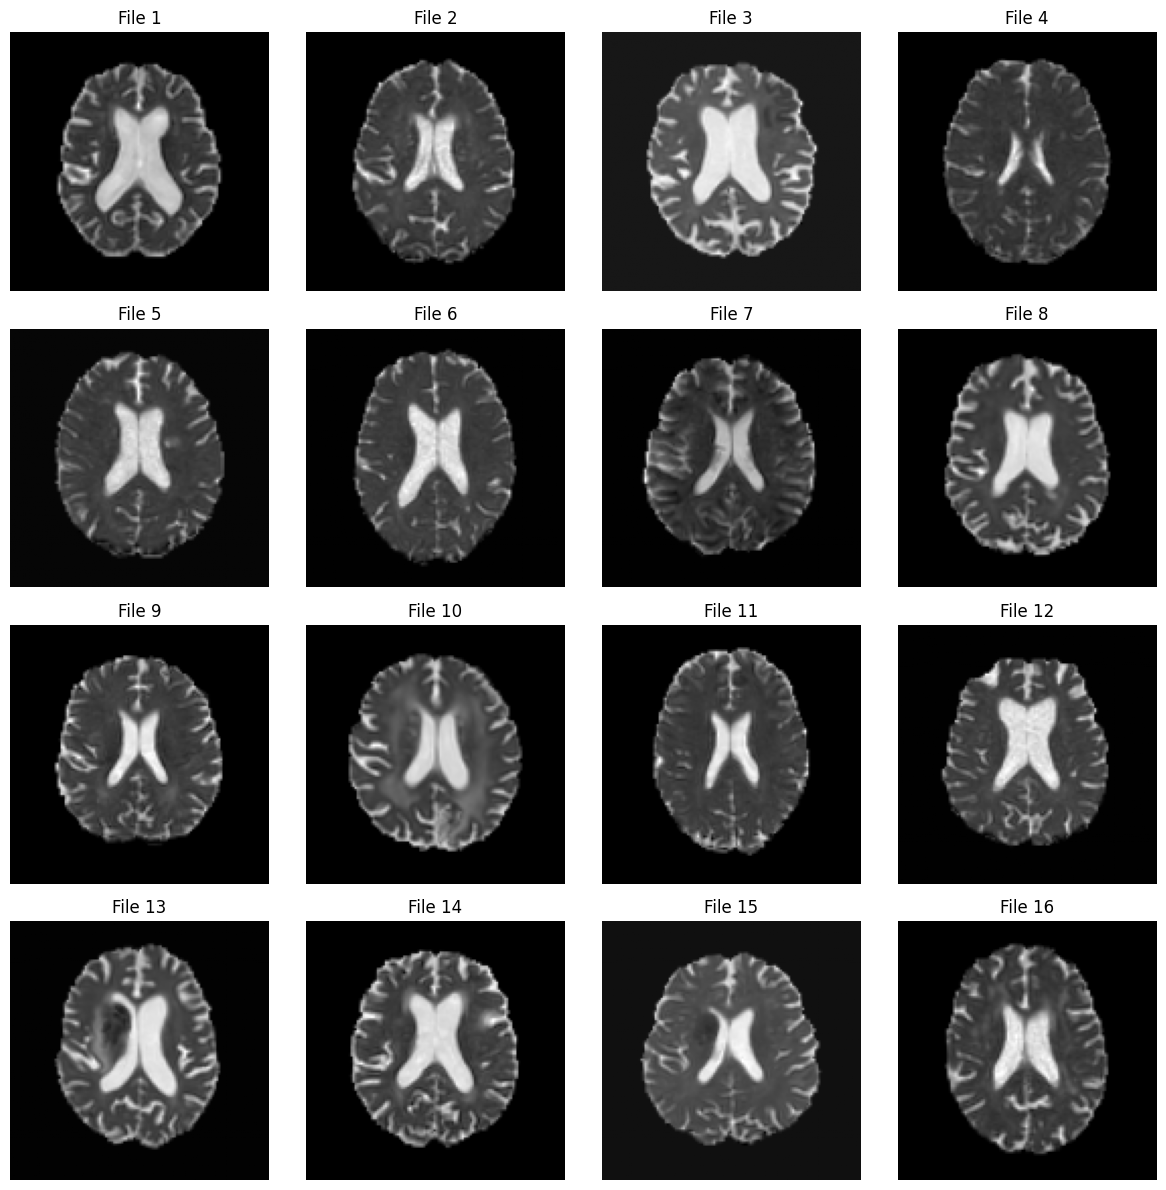

In [50]:
import matplotlib.pyplot as plt

# Get the first 16 files from the output folder
first_16_files = sorted(os.listdir(output_folder))[:16]

# Create a grid to display the slices
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, file in enumerate(first_16_files):
    if file.endswith(".nii") or file.endswith(".gz"):
        # Load the image
        image_path = os.path.join(output_folder, file)
        image = nib.load(image_path)
        image_data = image.get_fdata()
        print(image_data.shape)

        # Calculate the middle axial slice index
        middle_axial_index = image_data.shape[2] // 2

        # Extract the middle axial slice
        middle_axial_slice = image_data[:, :, middle_axial_index]

        # Display the slice in the grid
        ax = axes[i // 4, i % 4]
        ax.imshow(middle_axial_slice, cmap="gray")
        ax.set_title(f"File {i+1}")
        ax.axis("off")

plt.tight_layout()
plt.show()

[-4.12939995e-11 -3.86751915e-11 -3.32380477e-11 ...  9.99724209e-01
  9.99921143e-01  1.00000000e+00]
[-1.78757833e-16 -1.40458391e-16 -1.12721451e-16 ...  9.98995841e-01
  9.99949098e-01  1.00000000e+00]
[-1.49630986e-13 -1.47252707e-13 -1.36023097e-13 ...  9.99962807e-01
  9.99999702e-01  1.00000000e+00]
[-3.37564308e-16 -2.75281923e-16 -2.66575297e-16 ...  9.99795437e-01
  9.99810755e-01  1.00000000e+00]
[-1.77354757e-14 -1.61456626e-14 -1.13153802e-14 ...  9.99892473e-01
  9.99974728e-01  1.00000000e+00]
[-1.16876994e-16 -9.30245464e-17 -9.19403442e-17 ...  7.17597604e-01
  8.02337706e-01  8.79548430e-01]
[-5.21284405e-16 -5.05671893e-16 -4.37150316e-16 ...  9.98800159e-01
  9.99799311e-01  1.00000000e+00]
[-1.79191514e-16 -1.58781408e-16 -1.38981166e-16 ...  9.98709083e-01
  9.99567747e-01  1.00000000e+00]
[-6.11444624e-14 -5.62600334e-14 -4.81747312e-14 ...  9.99760628e-01
  9.99893367e-01  1.00000000e+00]
[-2.40259201e-16 -2.19950739e-16 -2.04317899e-16 ...  9.98830080e-01
  9.

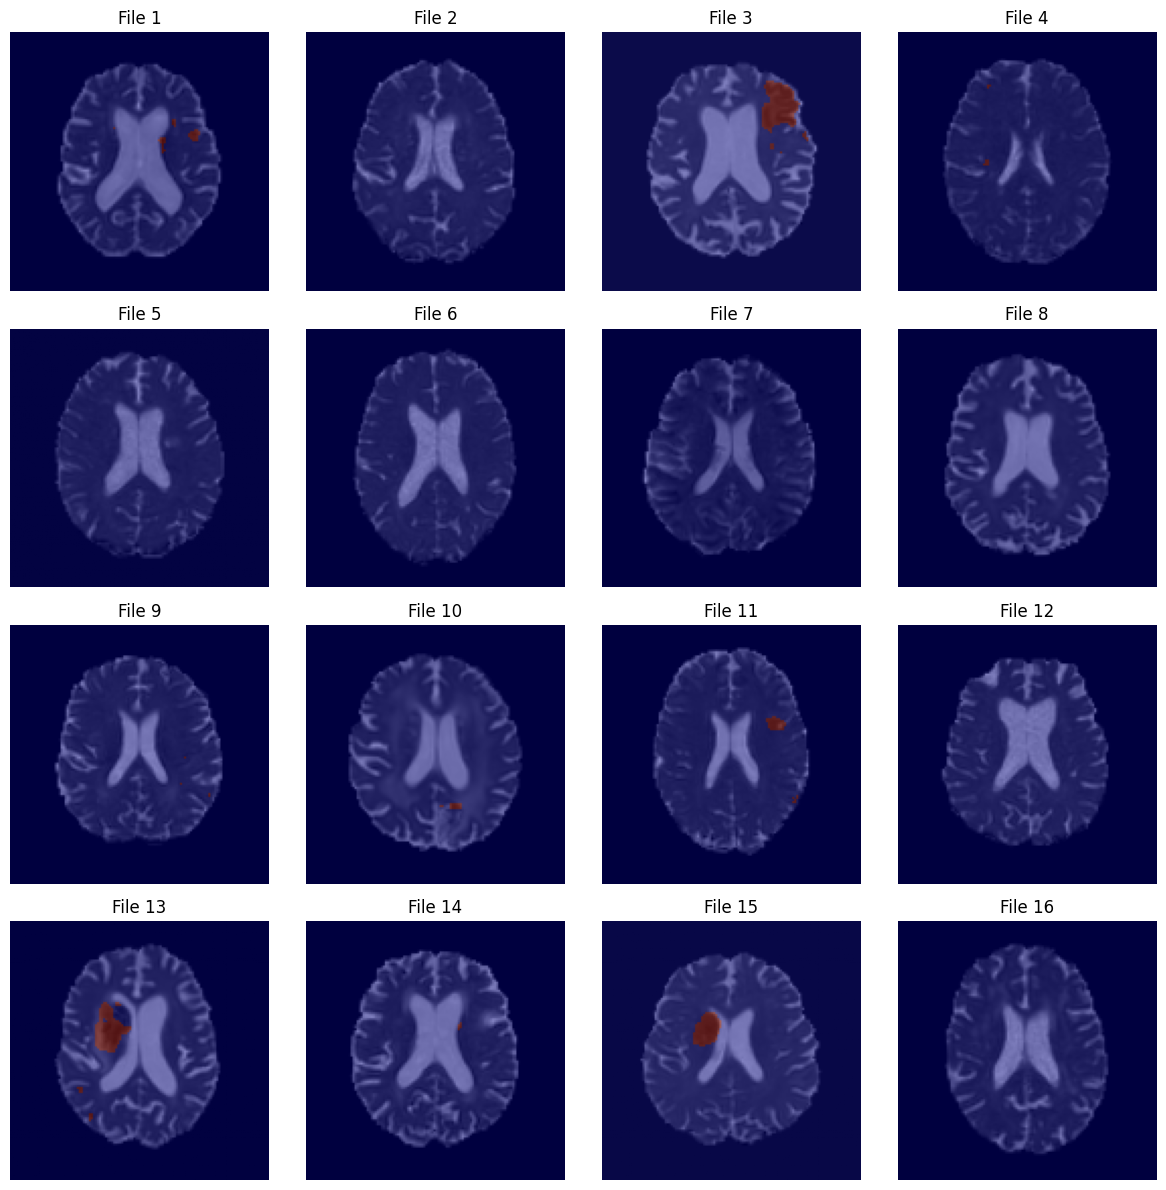

In [54]:
# Get the first 16 files from the output folder and corresponding masks
first_16_files = sorted(os.listdir(output_folder))[:16]
first_16_masks = sorted(os.listdir(output_folder_masks))[:16]

# Create a grid to display the slices with overlays
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, (file, mask_file) in enumerate(zip(first_16_files, first_16_masks)):
    if file.endswith(".nii") or file.endswith(".gz"):
        # Load the image
        image_path = os.path.join(output_folder, file)
        image = nib.load(image_path)
        image_data = image.get_fdata()

        # Load the corresponding mask
        mask_path = os.path.join(output_folder_masks, mask_file)
        mask = nib.load(mask_path)
        print(np.unique(mask.get_fdata()))
        mask_data = np.where(mask.get_fdata() > 0.5, 1, 0)

        # Calculate the middle axial slice index
        middle_axial_index = image_data.shape[2] // 2

        # Extract the middle axial slice for the image and mask
        middle_axial_slice = image_data[:, :, middle_axial_index]
        middle_mask_slice = mask_data[:, :, middle_axial_index]

        # Display the slice with overlay
        ax = axes[i // 4, i % 4]
        ax.imshow(middle_axial_slice, cmap="gray")
        ax.imshow(middle_mask_slice, cmap="jet", alpha=0.5)  # Overlay mask with transparency
        ax.set_title(f"File {i+1}")
        ax.axis("off")

plt.tight_layout()
plt.show()